# Naive Bayes Classification

Naive Bayes models are a groups of fast and simple classification algorithms that are often suitable for high-dimensional datasets. Because they are fast and have few tunable parameters, they end up being very useful as a baseline for classification problems. 

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods, which rely on Bayes's theorem, an equation describing the relationship of conditional probabilities of statistical quantities. In Bayesian classification, we want to find the probability of a label given some observed features, which we can write as $P(L~|~\text{features})$. We can express this in terms of quantities we can compute more directly:

$$
P(L~|~\text{features}) = \frac{P(\text{features}~|~L)P(L)}{P(\text{features})}
$$

If we are trying to decide between two labels, we can make this decision by computing the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~\text{features})}{P(L_2~|~\text{features})} = \frac{P(\text{features}~|~L_1) P(L_1)}{P(\text{features}~|~L_2) P(L_2)}
$$

Now we need some model by which we can compute $P(\text{features}~|~L_i)$ for each label. Such a model is called a _generative model_ because it specifies the hypothetical random process that generates the data. Specifying such a model for each label is the main piece of training a Bayesian classifier. The general form of such a training step is a very difficult task, but we can make it simpler by making some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: we make very naive assumptions about the generative model for each label in order to find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification. There are different types of naive Bayes classifiers, each of which rests on different naive assumptions about the data. We will examine a few of these in this section.

Let's begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Gaussian Naive Bayes

In this classifier, the assumption is that _data from each label is drawn from a simple Gaussian distribution_. Consider the following data:

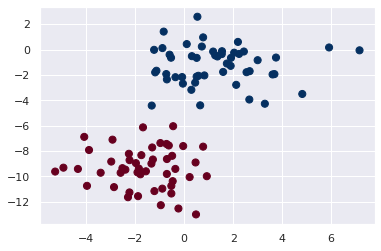

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

We can create a simple model extremely fast by assuming that the data is described by a Gaussian distribution with no covariance between dimensions. All we need to define such a distribution is to find the mean and the standard deviation of the points within each label, which would make for the fitting of the model. The result of this naive Gaussian assumption is shown in the following figure:

![Gaussian Naive Bayes](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.05-gaussian-NB.png)

The ellipses represent the Gaussian generative model for each label, with larger probability toward the center. With this generative model in place, we can easily compute the likelihood $P(\text{features}~|~L_i)$, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's `sklearn.naive_bayes.GaussianNB` estimator:

In [3]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

With the model fit, let's generate some new data to predict the label:

In [4]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

We can get a idea of where the decision boundary is by plotting this new data:

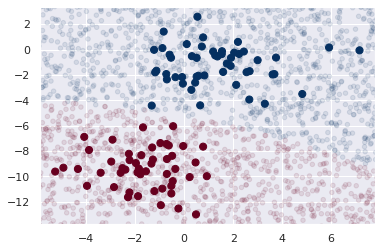

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classification. In general, the boundary in Gaussian naive Bayes is quadratic.

This Bayesian formalism naturally allows for probabilistic classification, which we can compute using the `predict_proba` method:

In [6]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

The columns gives us the posterior probabilities of the first and second label, respectively. 

Of course, the final classification will be only as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results. However, this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method!

## Multinomial Naive Bayes

Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution. The multinomial distribution describes the probability of observing counts among a number of categories, so multinomial naive Bayes is very appropriate for features that represent counts or count rates.

### Example: Classifying Text

Multinomial naive Bayes is often used in text classification, where the features are related to word counts of frequencies within the corpus. For this example, we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [7]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We will just select a few of these categories for the sake of simplicity:

In [8]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative sample of the data:

In [9]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we will use the TF-IDF vectorizer and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can simply apply the model to the training data, and predict labels for the test data:

In [11]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now we can evaluate the predictions to learn about the performance of the estimator. Let's take a look at the confusion matrix for this model:

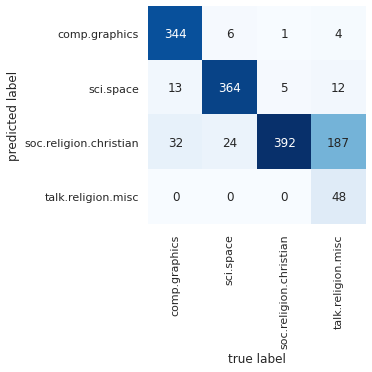

In [12]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

We can see that this very simple classifier can separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity. 

One cool thing here is the ability to determine the category for _any_ string, using the `predict()` method of this pipeline. This quick utility function will return the prediction for a single string for us:

In [13]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

We can now see this in action:

In [14]:
predict_category('sending a payload to the ISS')

'sci.space'

In [15]:
predict_category('determining the screen resolution')

'comp.graphics'

Although this is nothing more sophisticated than a simple probability model for the weighted frequency of each word in the string, the result is still astounding. Even a very naive algorithm, when used carefully, can be surprisingly effective.

## When to use Naive Bayes

Naive Bayesian classifier make very stringent assumptions about the data, thus they will generally not perform as well as a more complicated model. That said, they have several advantages:

- They are very fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often easy to interpret
- They have very few (if any) tunable parameters

All these advantages mean that a naive Bayesian classifier is often a good choice as a initial baseline classification. If it performs well, then problem solved. If it doesn't, then we can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in the following situations:

- When the naive assumptions actually match the data (_very_ rare in practice)
- For very well-separated categories, when model complexity is less important 
- For very high-dimensional data, when model complexity is less important